# Data exploration
This notebooks provides tools to explore the datasets at hand. It can be useful to detect potential bias in data.

In [53]:
import numpy as np
import pandas as pd
import os
import cv2
import json

import tensorflow as tf

from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER= './drive/MyDrive/ml-project-2-la_team/data/3_kinds_pneumonia/'
NORMAL_FOLDER = DATA_FOLDER + 'Normal/'
PNEUMONIA_FOLDER = DATA_FOLDER + 'Pneumonia-Bacterial/'
IMAGES_FILES = '*.jpg'

AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]

In [3]:
# mount google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load images filenames

In [4]:
def load_images_names(data_folder):
    return tf.io.gfile.glob(data_folder)

normal_img_names = load_images_names(NORMAL_FOLDER + IMAGES_FILES)
pneumonia_img_names = load_images_names(PNEUMONIA_FOLDER + IMAGES_FILES)

In [5]:
print("# of normal images: {}".format(len(normal_img_names)))
print("# of pneumonia images: {}".format(len(pneumonia_img_names)))

# of normal images: 3278
# of pneumonia images: 3008


# Get images from filenames
Labels: 1 (True) for pneumonia, 0 (False) for normal

In [6]:
normal_list_ds = tf.data.Dataset.from_tensor_slices(normal_img_names)
pneumonia_list_ds = tf.data.Dataset.from_tensor_slices(pneumonia_img_names)

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] != "Normal"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor

    # TODO check that the number of channels is correct
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    # img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    
    #return tf.image.resize(img, IMAGE_SIZE)
    return img

def read_images_from_filenames(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

normal_ds = normal_list_ds.map(read_images_from_filenames, num_parallel_calls=AUTOTUNE)
pneumonia_ds = pneumonia_list_ds.map(read_images_from_filenames, num_parallel_calls=AUTOTUNE)

In [8]:
for image, label in normal_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

for image, label in pneumonia_ds.take(2):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (1421, 1805, 3)
Label:  False
Image shape:  (1067, 1422, 3)
Label:  False
Image shape:  (151, 494, 3)
Label:  True
Image shape:  (672, 1080, 3)
Label:  True


In [9]:
# Iterate through all files to get image shapes.
# To save time, you can just load the generated txt files with the cell below
generate_shapes = False

if generate_shapes:
    normal_img_shapes = []
    print("Iterate over normal values")
    val = 0
    for image, _ in normal_ds.as_numpy_iterator():
        if val%100==0:
            print(val)
        normal_img_shapes.append(image.shape)
        val+=1

    pneumonia_img_shapes = []
    print("Iterate over pn values")
    val = 0
    for image, _ in pneumonia_ds.as_numpy_iterator():
        if val%100==0:
            print(val)
        pneumonia_img_shapes.append(image.shape)
        val+=1

    assert(len(normal_img_shapes) == len(normal_img_names))
    assert(len(pneumonia_img_shapes) == len(pneumonia_img_names))

    # write to txt files to reuse later
    normal_img_dict = {}
    for i, img_name in enumerate(normal_img_names):
        normal_img_dict[img_name] = normal_img_shapes[i]

    pneumonia_img_dict = {}
    for i, img_name in enumerate(pneumonia_img_names):
        pneumonia_img_dict[img_name] = pneumonia_img_shapes[i]

    with open(DATA_FOLDER + 'normal_img_shapes.txt', 'w', encoding='utf-8') as normal_file:
        json.dump(normal_img_dict, normal_file)

    with open(DATA_FOLDER + 'pneumonia_img_shapes.txt', 'w', encoding='utf-8') as pneumonia_file:
        json.dump(pneumonia_img_dict, pneumonia_file)

In [10]:
if not generate_shapes:
    # Use this cell if the shapes have already been generated
    with open(DATA_FOLDER + 'normal_img_shapes.txt', 'r', encoding='utf-8') as normal_file:
        normal_img_dict = json.load(normal_file)

    with open(DATA_FOLDER + 'pneumonia_img_shapes.txt', 'r', encoding='utf-8') as pneumonia_file:
        pneumonia_img_dict = json.load(pneumonia_file)

In [35]:
def convert_dict_to_df(img_dict):
    def extract_img_id(image_filename):
        img_name = image_filename.split('/')[-1]
        return int(img_name.split('(')[1].split(')')[0])


    df = pd.DataFrame(img_dict)
    df.columns = df.columns.map(extract_img_id)
    df = df.T
    df.columns = ['H', 'W', 'C'] # height, width, # channels
    df['W_H_ratio'] = df['W'] / df['H']
    return df

normal_df = convert_dict_to_df(normal_img_dict)
normal_df.head()

,H,W,C,W_H_ratio
3051,1421,1805,3,1.270232
3047,1067,1422,3,1.332709
3043,2431,2340,3,0.962567
3049,1337,1592,3,1.190726
3050,1271,1546,3,1.216365


In [36]:
pn_df = convert_dict_to_df(pneumonia_img_dict)
pn_df.head()

,H,W,C,W_H_ratio
2821,151,494,3,3.271523
2815,672,1080,3,1.607143
2802,1088,1488,3,1.367647
281,300,400,3,1.333333
2803,816,1352,3,1.656863


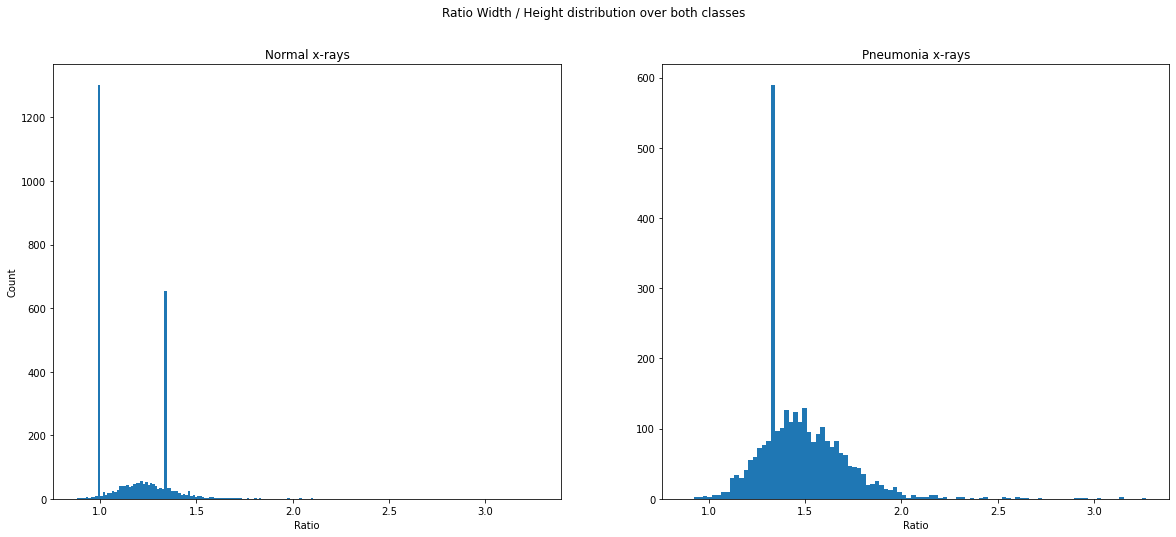

In [69]:
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(20, 8))
nb_bins = 100

ax[0].hist(normal_df['W_H_ratio'], bins=nb_bins)
ax[0].set_title("Normal x-rays")
ax[0].set_xlabel("Ratio")
ax[0].set_ylabel("Count")

ax[1].hist(pn_df['W_H_ratio'], bins=nb_bins)
ax[1].set_title("Pneumonia x-rays")
ax[1].set_xlabel("Ratio")

plt.suptitle("Ratio Width / Height distribution over both classes")
plt.show()